## EECS491 A4 E2
### Tristan Maidment (tdm47)

#### Goal
The goal for this exerise is to implement the covariance portion of the EM algorithm.  Since the previous exercise provided a majority of the functionality needed for this exercise, I will not provide redundant comments, and only comment on added functionality.

#### Implementation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mnist
import copy
from scipy.stats import chi2, multivariate_normal

ngmm = 2

In [2]:
mu = np.asarray([[1,60], 
                 [3, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 42]], 
                    [[0.5, 0], 
                     [0, 3]]]
                  ).astype('float')

truth_mu = np.asarray([[2, 70], 
                 [4, 80]]
               ).astype('float')

truth_sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')

In [3]:
mu_dist_1 = np.random.multivariate_normal(truth_mu[0], truth_sigma[0], 50)
mu_dist_2 = np.random.multivariate_normal(truth_mu[1], truth_sigma[1], 50)

In [4]:
## functions used from the example code provided in class for plotting the distributions.
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

In [5]:
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

The only change from the previous exercise is the inclusion of the covariance maximiation step.  This step is similar to the maximization of the mean, but it adds the weighted (by the `posterior`) covariance of each data point in the domain.  The covariance of each point is found by doing an outer product `np.outer`, of the distance of the datapoint from the mean, and it's transpose.

In [6]:
def expectation(data, gmmcp):
    num = np.zeros((len(gmmcp), data.shape[0]))
    den = np.zeros((len(gmmcp), data.shape[0]))
    for k in range(len(gmmcp)):
        #print(gmmcp[k]["mean"], gmmcp[k]["covariance"])
        num[k] = gmmcp[k]["prior"] * multivariate_normal.pdf(data, gmmcp[k]["mean"], gmmcp[k]["covariance"])
        for l in range(len(gmmcp)):
            den[k] += gmmcp[l]["prior"] * multivariate_normal.pdf(data, gmmcp[l]["mean"], gmmcp[l]["covariance"])
    return np.divide(num, den)

def maximization(posterior, data, gmmcp):
    # calculate Nk
    N = np.zeros(len(gmmcp))
    for k in range(N.shape[0]):
        N[k] = np.sum(posterior[k])
    
    mu = np.zeros((len(gmmcp), len(gmmcp[0]["mean"])))
    for k in range(mu.shape[0]):
        for n in range(data.shape[0]):
            mu[k] += posterior[k, n] * data[n] 
        gmmcp[k]["mean"] = 1/N[k] * mu[k]

    sigma = np.zeros((len(gmmcp), data.shape[1], len(gmmcp[0]["covariance"])))
    for k in range(sigma.shape[0]):
        for n in range(data.shape[0]):
            sigma[k] += posterior[k, n] * np.outer((data[n] - gmmcp[k]["mean"]), (data[n] - gmmcp[k]["mean"]).T)
        gmmcp[k]["covariance"] = 1/N[k] * sigma[k]
        
    prior = np.zeros(len(gmmcp))
    for k in range(prior.shape[0]):
        prior[k] = np.divide(N[k],N.sum())
        gmmcp[k]["prior"] = prior[k]
        
    return gmmcp

Cluster 0 {'mean': array([ 1., 60.]), 'covariance': array([[ 1.,  0.],
       [ 0., 42.]]), 'prior': 0.5} Cluster 1 {'mean': array([ 3., 80.]), 'covariance': array([[0.5, 0. ],
       [0. , 3. ]]), 'prior': 0.5}


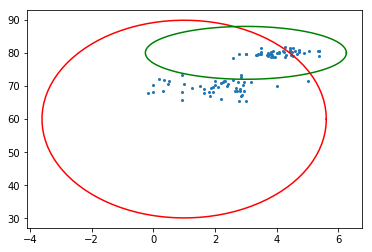

In [9]:
data = np.concatenate((mu_dist_1, mu_dist_2), axis=0)
print("Cluster 0", gmm[0], "Cluster 1", gmm[1])
gmmplot(data, gmm)

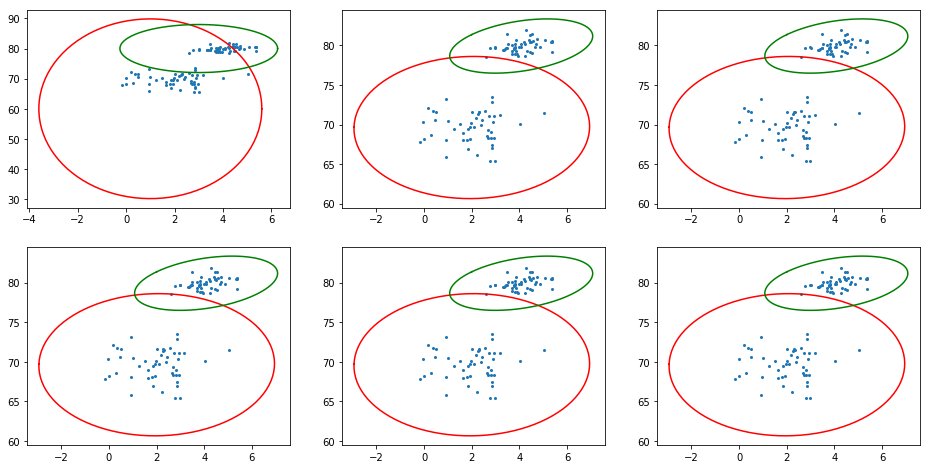

In [10]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

pi = np.array([0.5, 0.5])
# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    #plt.show()
    # excute EM-Algorithm
    for j in range(5):
        #print((gmmcp[0]["covariance"]).shape)
        posterior = expectation(data, gmmcp)
        #print("Posterior:", posterior)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

### Conclusion
As we can see, the elipses depicting the clusters "tighten" up around the data, providing a more accurate representation than just the mean maximization from the previous exercise.